In [4]:
# %% 
# ----------------------------
# Imports
# ----------------------------
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os

# ----------------------------
# Parameters
# ----------------------------
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20
NUM_CLASSES = 4  # apple, rectangle, triangle, inverted_triangle, hourglass
DATA_DIR = "segmented_dataset"  # all images in subfolders per class

# ----------------------------
# Data Generators with validation split
# ----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # set as training data
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # set as validation data
)

# ----------------------------
# Build Model (MobileNetV2 backbone)
# ----------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Freeze backbone for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ----------------------------
# Train model
# ----------------------------
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# ----------------------------
# Save model
# ----------------------------
model.save("final2.h5")
print("Model saved as 'body_shape_model_simple.h5'")


Found 174 images belonging to 4 classes.
Found 42 images belonging to 4 classes.
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3621 - loss: 1.5198 - val_accuracy: 0.3333 - val_loss: 1.6827
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 992ms/step - accuracy: 0.6092 - loss: 0.9558 - val_accuracy: 0.3810 - val_loss: 1.4295
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7586 - loss: 0.7164 - val_accuracy: 0.4524 - val_loss: 1.5885
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 913ms/step - accuracy: 0.7874 - loss: 0.5675 - val_accuracy: 0.4524 - val_loss: 1.7283
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8103 - loss: 0.4969 - val_accuracy: 0.3571 - val_loss: 1.7020
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 902ms/step - accuracy: 0.8391 - loss: 0.4500 - val_accuracy: 0.3095 - val_loss: 1.7327
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 807ms/step - accuracy: 0.8966 - loss: 0.3197 - val_accuracy: 0.3333 - val_loss: 2.1132
Epoch 8/20
11/11 ━━━━━━━━━

Model saved as 'body_shape_model_simple.h5'


In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
CLASS_LABELS = list(val_generator.class_indices.keys())

val_generator.reset()
val_preds = model.predict(val_generator)
val_pred_labels = np.argmax(val_preds, axis=1)
val_true_labels = val_generator.classes

print("\nValidation Accuracy: {:.2f}%".format(100*np.mean(val_pred_labels==val_true_labels)))

# Classification report
print("\nClassification Report:")
print(classification_report(val_true_labels, val_pred_labels, target_names=CLASS_LABELS))

# Confusion matrix (helps to check for bias)
cm = confusion_matrix(val_true_labels, val_pred_labels)
print("\nConfusion Matrix:")
print(cm)

# ----------------------------
# Bias Checking
# ----------------------------
print("\nBias Checking per Class (Predicted vs True counts):")
for i, label in enumerate(CLASS_LABELS):
    true_count = np.sum(val_true_labels == i)
    pred_count = np.sum(val_pred_labels == i)
    print(f"{label}: True = {true_count}, Predicted = {pred_count}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 824ms/step

Validation Accuracy: 21.43%

Classification Report:
                  precision    recall  f1-score   support

           Apple       0.17      0.10      0.12        10
       Hourglass       0.27      0.25      0.26        12
InvertedTriangle       0.00      0.00      0.00        10
       Rectangle       0.23      0.50      0.31        10

        accuracy                           0.21        42
       macro avg       0.17      0.21      0.17        42
    weighted avg       0.17      0.21      0.18        42


Confusion Matrix:
[[1 1 1 7]
 [2 3 1 6]
 [3 3 0 4]
 [0 4 1 5]]

Bias Checking per Class (Predicted vs True counts):
Apple: True = 10, Predicted = 6
Hourglass: True = 12, Predicted = 11
InvertedTriangle: True = 10, Predicted = 3
Rectangle: True = 10, Predicted = 22


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.3 MB 3.4 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/11.3 MB 3.2 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.3 MB 3.5 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/11.3 MB 3.8 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.3 MB 2.7 MB/s eta 0:00:04
   ------------ --------------------------- 3.7/11.3 MB 2.9 MB/s eta 0:00:03
   ----------------- ---------------------- 5.0/11.3 MB 3.3 MB/s eta 0:00:02
   -------------------- ------------------- 5.8/11.3 MB 3.5 MB/s eta 0:00:02
   ------------------------ --------------- 7.1/11.3 MB 3.7 MB/s eta 0:00:02
   ------------------------- -------------- 7.3/11.3 MB 3.7 MB/s eta 0:00:02
   --------------------------- ----------

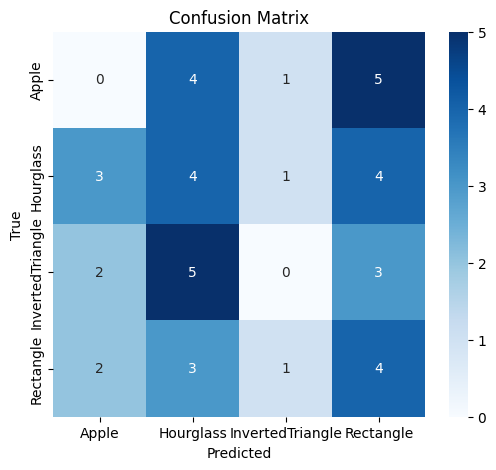

In [17]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
